In [1]:
import gzip
import random
import string
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from torch import nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 

from gensim.models import Word2Vec

from tqdm import tqdm, notebook

%load_ext memory_profiler

In [2]:
data_path = 'aita_raw.csv'

In [3]:
df = pd.read_csv(data_path)
df = df.dropna(axis=0)
df['verdict'] = df['verdict'].str.lower()
df

,id,timestamp,title,body,edited,verdict,score,num_comments
0,1ytr72,1.393275e+09,[AITA] Construction worker here,I have been on a parking structure project for...,False,too close to call,63,9.0
1,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0
2,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0
3,1yu41e,1.393282e+09,[AITA] I Put My Empty Beer on a Bar Table,"Relevant Facts:\n\n1) It was a crowded bar, th...",False,nothing happened,45,7.0
4,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0
...,...,...,...,...,...,...,...,...
167755,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the a-hole,1373,304.0
167756,ex97ye,1.580577e+09,AITA for refusing to give my ticket to my brot...,[deleted],False,no a-holes here,4,16.0
167758,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the a-hole,4,15.0
167759,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the a-hole,280,140.0


In [4]:
counts = df['verdict'].value_counts()
print(counts)
v = df['verdict']
df = df[v.replace(counts.gt(300))]
replace_dict = {
    'not the asshole': 'not the a-hole',
    'no a--holes here': 'no a-holes here'
}
df = df.replace({'verdict': replace_dict})

not the a-hole        75393
asshole               27449
no a-holes here       15129
everyone sucks         7417
not enough info        2713
                      ...  
douchenozzle              1
asshole in theory         1
overly sensitive          1
asshole ...i guess        1
tree law!                 1
Name: verdict, Length: 410, dtype: int64


In [5]:
df['verdict'].value_counts()

not the a-hole     75766
asshole            27449
no a-holes here    15432
everyone sucks      7417
not enough info     2713
Name: verdict, dtype: int64

In [6]:
v = df['verdict']
df = df[v.replace(counts.gt(3000))]
replace_dict = {
    'no a-holes here': 'not the a-hole',
    'everyone sucks': 'asshole'
}
df = df.replace({'verdict': replace_dict})
df['verdict'].value_counts()

not the a-hole    91198
asshole           34866
Name: verdict, dtype: int64

In [7]:
v = df['body']
df = df[v != '[deleted]']
df['verdict'].value_counts()

not the a-hole    71536
asshole           26863
Name: verdict, dtype: int64

In [8]:
verdicts = df['verdict'].unique()
print(verdicts)
num_classes = len(verdicts)
print(num_classes)

['asshole' 'not the a-hole']
2


In [9]:
class LemmaTokenizer:
    ignore_tokens = string.punctuation
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if not any(i in t for i in self.ignore_tokens) and len(t) > 2]

In [10]:
df['edited'] = [0 if 'false' in d else 1 for d in df['edited'].str.lower() ]

In [11]:
df['num_comments'] = np.log(df['num_comments'])
df['score'] = np.log(df['score'])

In [12]:
df['body'] = df['body'].str.lower() # convert to lowercase
df['title'] = df['title'].str.lower() # convert to lowercase
df['body'] = df[['title', 'body']].agg(' '.join, axis=1)

df['body'] = df['body'].str.replace('\'', '') # replace apostrophe with empty
df['body'] = df['body'].str.replace('[^\w\s]', ' ') # replace characters that are not alphanumeric or spaces
# df['body'] = df['body'].str.replace('\d+', '') # replace numbers

In [13]:
classes = df['verdict'].unique()
verdict_map = dict(zip(classes, range(len(classes))))
df['verdict'] = df['verdict'].replace(verdict_map)
df

,id,timestamp,title,body,edited,verdict,score,num_comments
1,1ytxov,1.393279e+09,[aita] i wrote an explanation in til and came ...,aita i wrote an explanation in til and came ...,0,0,3.951244,2.564949
2,1yu29c,1.393281e+09,[aita] threw my parent's donuts away,aita threw my parents donuts away my parents...,1,0,4.941642,3.295837
4,1yu8hi,1.393285e+09,i told a goth girl she looked like a clown.,i told a goth girl she looked like a clown i ...,0,1,4.304065,2.708050
5,1yuc78,1.393287e+09,[aita]: argument i had with another redditor i...,aita argument i had with another redditor i...,1,0,3.091042,1.098612
7,1yugsc,1.393289e+09,aita had a disagreement about les miserables w...,aita had a disagreement about les miserables w...,0,0,3.091042,2.708050
...,...,...,...,...,...,...,...,...
167754,ex94w5,1.580577e+09,aita for telling my sister she is being a spoi...,aita for telling my sister she is being a spoi...,1,1,2.772589,3.135494
167755,ex970f,1.580577e+09,aita for telling my husband to f* off after he...,aita for telling my husband to f off after he...,1,1,7.224753,5.717028
167758,ex9dwo,1.580578e+09,aita for attempting to keep my students out of...,aita for attempting to keep my students out of...,0,1,1.386294,2.708050
167759,ex9egs,1.580578e+09,wibta if i left my brothers fate up to the state?,wibta if i left my brothers fate up to the sta...,0,1,5.634790,4.941642


In [14]:
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df['verdict'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['verdict'])

In [15]:
# del df

In [16]:
transformed_data = df_train[['edited', 'score', 'num_comments']].to_numpy()
labels = df_train['verdict']

In [17]:
tokenizer=LemmaTokenizer()
word_list = ['aita']

stop_words = set(ENGLISH_STOP_WORDS.union(word_list))
tokenized_stop = tokenizer(' '.join(stop_words))

In [18]:
vectorizer = TfidfVectorizer(max_features=1000, sublinear_tf=True, max_df=0.95, 
                             min_df=5, ngram_range=(1, 2), tokenizer=tokenizer, stop_words=tokenized_stop)
# vectorizer = TfidfVectorizer(max_features=1000, sublinear_tf=True, max_df=0.95, 
#                              min_df=5, ngram_range=(1, 2))
text_features = vectorizer.fit_transform(df_train['body']).toarray()
print(text_features.shape)

(78719, 1000)


In [19]:
feature_names = vectorizer.get_feature_names()
feature_names = ['edited_param', 'score_param', 'num_comments_param'] + feature_names

In [20]:
%memit

peak memory: 2349.26 MiB, increment: -2.23 MiB


In [21]:
text_features = np.array(np.hstack((transformed_data, text_features)))
print(text_features.shape)

(78719, 1003)


In [22]:
%memit

peak memory: 2351.67 MiB, increment: 0.00 MiB


In [23]:
X_train = text_features
y_train = np.array(labels)
input_size = len(X_train[0])
print(input_size)
print(X_train.shape)
print(y_train.shape)

1003
(78719, 1003)
(78719,)


In [24]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_under, y_under = rus.fit_resample(X_train, y_train)
# print(X_under.shape)
# print(y_under.shape)

In [25]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_over, y_over = sm.fit_resample(X_train, y_train)
print(X_over.shape)
print(y_over.shape)

(114458, 1003)
(114458,)


In [26]:
%memit

peak memory: 3393.76 MiB, increment: 0.00 MiB


In [27]:
feature_rank = SelectKBest(chi2, k=500)
feature_rank.fit(X_train, y_train)

SelectKBest(k=500, score_func=<function chi2 at 0x7f5e56c25950>)

In [60]:
feat = []
for i, (score, feature) in enumerate(zip(feature_rank.scores_, feature_names)):
    feat.append((score, feature))
    
dfObj = pd.DataFrame(feat, columns = ['chi_squared', 'word']) 
top = dfObj.loc[~dfObj['word'].str.endswith('param')].sort_values(by=['chi_squared'], ascending = False)[:10]
top

,chi_squared,word
261,65.340016,edit
574,45.940423,mom
967,41.135903,wife
581,33.735919,mother
193,31.671510,dad
463,23.110176,joke
357,22.486819,girl
945,22.396722,wanting
628,20.185476,parent
296,19.464503,family


In [61]:
def get_word_influence(word):
    word_in = df.loc[df['body'].str.contains(word)]
    word_out = df.loc[~df['body'].str.contains(word)]
    word_p = sum(word_in['verdict']) / len(word_in)
    non_word_p = sum(word_out['verdict']) / len(word_out)

    if word_p < non_word_p:
        print(f'More likely to BE a-hole when contains word "{word}"')
    else:
        print(f'More likely to be NOT a-hole when contains word "{word}"')

    print(f'Difference of {(word_p - non_word_p)*100}% \n')
    print(f'Probability of NTA with word "{word}": {word_p}')
    print(f'Probability of NTA without word "{word}": {non_word_p}')
    
    return word_p, non_word_p

In [62]:
prob_results = []
for w in top['word']:
    word_p, non_word_p = get_word_influence(w)
    prob_results.append((word_p, non_word_p))
    print('\t -------------- \n')

More likely to BE a-hole when contains word "edit"
Difference of -10.066037647680181% 

Probability of NTA with word "edit": 0.6480854266629034
Probability of NTA without word "edit": 0.7487458031397052
	 -------------- 

More likely to be NOT a-hole when contains word "mom"
Difference of 6.21062165243803% 

Probability of NTA with word "mom": 0.7748505645339827
Probability of NTA without word "mom": 0.7127443480096024
	 -------------- 

More likely to BE a-hole when contains word "wife"
Difference of -6.652583845422011% 

Probability of NTA with word "wife": 0.6667028434990232
Probability of NTA without word "wife": 0.7332286819532433
	 -------------- 

More likely to be NOT a-hole when contains word "mother"
Difference of 7.552409692732532% 

Probability of NTA with word "mother": 0.7919045898084568
Probability of NTA without word "mother": 0.7163804928811315
	 -------------- 

More likely to be NOT a-hole when contains word "dad"
Difference of 6.881675560116407% 

Probability of NTA

In [63]:
prob_df = pd.DataFrame(prob_results,index=top['word'], columns=['word_p', 'non_word_p'])
prob_df['p_diff'] = (prob_df['word_p'] - prob_df['non_word_p'])
prob_df['p_diff_percent'] = prob_df['p_diff'] / prob_df['non_word_p']
prob_df['nta_pos'] = prob_df['p_diff'] > 0
prob_df

,word_p,non_word_p,p_diff,p_diff_percent,nta_pos
word,,,,,
edit,0.648085,0.748746,-0.100660,-0.134439,False
mom,0.774851,0.712744,0.062106,0.087137,True
wife,0.666703,0.733229,-0.066526,-0.090730,False
mother,0.791905,0.716380,0.075524,0.105425,True
dad,0.785724,0.716907,0.068817,0.095991,True
joke,0.654160,0.730515,-0.076355,-0.104522,False
girl,0.691234,0.737774,-0.046540,-0.063082,False
wanting,0.784209,0.716020,0.068189,0.095233,True
parent,0.762526,0.714764,0.047762,0.066823,True


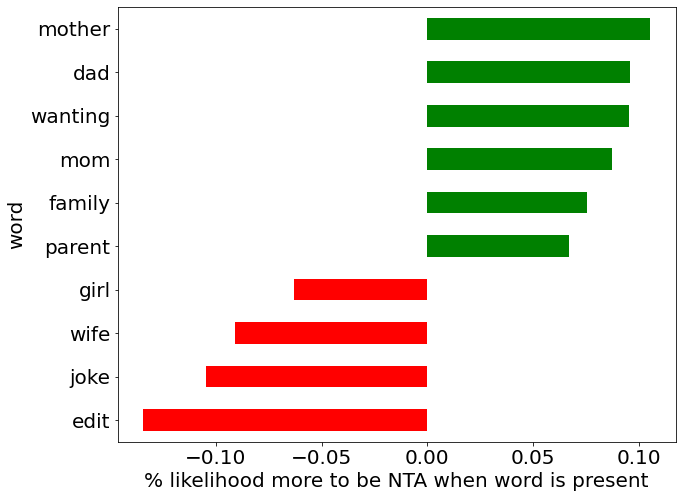

In [88]:
prob_df_sorted = prob_df.sort_values(by=['p_diff_percent'], ascending=True)
ax = prob_df_sorted['p_diff_percent'].plot(kind='barh', 
                                           color=prob_df_sorted.nta_pos.map({True: 'g', False: 'r'}), 
                                           figsize=(10,8))
ax.set_xlabel('% likelihood more to be NTA when word is present', fontsize=20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

In [31]:
transformed_val = df_val[['edited', 'score', 'num_comments']].to_numpy()
labels_val = df_val['verdict']
X_val = np.array(np.hstack((transformed_val, vectorizer.transform(df_val['body']).toarray())))
y_val = np.array(labels_val)
del transformed_val
print(X_val.shape)
print(y_val.shape)

(9840, 1003)
(9840,)


In [32]:
%memit

peak memory: 3473.16 MiB, increment: -2.00 MiB


In [33]:
# process = make_pipeline(PowerTransformer(method='yeo-johnson'))
# ct = ColumnTransformer([("power", process, [x for x in range(0, 6)])], remainder='passthrough')
# X_train = ct.fit_transform(X_train)
# X_test = ct.transform(X_test)

In [34]:
train_dataset = Data.TensorDataset(Variable(torch.from_numpy(X_over.astype(np.float32))), 
                                   Variable(torch.from_numpy(y_over.astype(np.long))))
test_dataset = Data.TensorDataset(Variable(torch.from_numpy(X_val.astype(np.float32))), 
                                  Variable(torch.from_numpy(y_val.astype(np.long))))

In [35]:
class TrainHelper():
    '''
    Helper class that makes it a bit easier and cleaner to define the training routine
    
    '''
    
    def __init__(self,model,train_set,test_set,opts):
        self.model = model 
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=opts['lr'], weight_decay=opts['weight_decay']) # optimizer method for gradient descent
        self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=opts['batch_size'],
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=opts['batch_size'],
                                                       shuffle=True)
        
    def train(self):
        self.model.train() #put model in training mode
        self.train_accuracy = []
        self.train_bacc = []

        for epoch in range(self.epochs):
            self.tr_loss = []
            for i, (data,labels) in notebook.tqdm(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):
                self.model.train()
                data, labels = data.to(self.device),labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(data)  
                loss = self.criterion(outputs, labels) 
                loss.backward()                        
                self.optimizer.step()                  
                self.tr_loss.append(loss.item())
                y_pred_softmax = torch.log_softmax(outputs.data, dim = 1)
                _, predicted = torch.max(y_pred_softmax, dim = 1)
#                 self.train_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
                self.train_accuracy.append(accuracy_score(labels.cpu(), predicted.cpu()))
                self.train_bacc.append(balanced_accuracy_score(labels.cpu(), predicted.cpu()))

            
            self.test(epoch) # run through the validation set
        
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_accuracy = []
            self.test_bacc = []

            
            for i, (data, labels) in enumerate(self.test_loader):
                
                data, labels = data.to(self.device),labels.to(self.device)
                
                # pass data through network
                # turn off gradient calculation to speed up calcs and reduce memory
                with torch.no_grad():
                    outputs = self.model(data)
                
                # make our predictions and update our loss info
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                y_pred_softmax = torch.log_softmax(outputs.data, dim = 1)
                _, predicted = torch.max(y_pred_softmax, dim = 1)
                self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
#                 self.test_accuracy.append(accuracy_score(labels.cpu(), predicted.cpu()))
                self.test_bacc.append(balanced_accuracy_score(labels.cpu(), predicted.cpu()))

            
            print('epoch: {}, train loss: {}, test loss: {}, train acc: {}, train balacc: {}, test acc: {}, test balacc: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), 
                  np.mean(self.train_accuracy), np.mean(self.train_bacc), np.mean(self.test_accuracy), np.mean(self.test_bacc)))

In [36]:
class FFNet(torch.nn.Module):
    def __init__(self, input_size, classes):
        super(FFNet, self).__init__()

#         self.fc1 = torch.nn.Linear(input_size, 1000)
#         self.relu1 = torch.nn.ReLU()
#         self.drop1 = torch.nn.Dropout(0.5)
#         self.bn1 = torch.nn.BatchNorm1d(1000)

        self.fc2 = torch.nn.Linear(input_size, 500)
        self.relu2 = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout(0.5)
        self.bn2 = torch.nn.BatchNorm1d(500)


        self.fc3 = torch.nn.Linear(500, 250)
        self.relu3 = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout(0.5)
        self.bn3 = torch.nn.BatchNorm1d(250)


        self.fc4 = torch.nn.Linear(250, classes)

    def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.drop1(x)
#         x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.bn2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.bn3(x)
        
        x = self.fc4(x)
        return x


In [37]:
class LSTMNet(torch.nn.Module):
    def __init__(self, input_size, classes):
        super(LSTMNet, self).__init__()
        self.hidden = 128
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=self.hidden,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(2*self.hidden, classes)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x, _ = self.lstm(x)
        x = self.drop(x)
        x = self.fc1(x)
        x = torch.squeeze(x)
        return x


In [40]:
model = LSTMNet(input_size=input_size, classes=num_classes)
opts = {
    'lr': 5e-5,
    'weight_decay': 4e-3,
    'epochs': 5,
    'batch_size': 64
}



NetTrainer = TrainHelper(model = model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)

In [41]:
NetTrainer.train()


epoch: 1, train loss: 0.6381258508258189, test loss: 0.6056703120083003, train acc: 0.6407331663585158, train balacc: 0.6412200947629468, test acc: 0.6757643398268399, test balacc: 0.6581694832202504



epoch: 2, train loss: 0.5940363372818194, test loss: 0.6074663681256307, train acc: 0.663727251472675, train balacc: 0.663832884275384, test acc: 0.6735660173160173, test balacc: 0.6639271451257882



epoch: 3, train loss: 0.5844973251431798, test loss: 0.5994932171586272, train acc: 0.6738123647360652, train balacc: 0.6738272342972962, test acc: 0.686620670995671, test balacc: 0.6679440163249805



epoch: 4, train loss: 0.5790768261059761, test loss: 0.5941052970948157, train acc: 0.6799543887324246, train balacc: 0.6800070690409069, test acc: 0.691321699134199, test balacc: 0.6677941033235539



epoch: 5, train loss: 0.5755358989542593, test loss: 0.6170292345734386, train acc: 0.6839373629444898, train balacc: 0.6839353978673471, test acc: 0.6706236471861471, test balacc: 0.6656593867548088


In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [102]:
clf = LinearSVC(max_iter=10000, verbose=2)
clf.fit(X_over, y_over)

[LibLinear]

LinearSVC(max_iter=10000, verbose=2)

In [103]:
y_pred = clf.predict(X_val)
TP_ = np.logical_and(y_pred, y_val)
FP_ = np.logical_and(y_pred, np.logical_not(y_val))
TN_ = np.logical_and(np.logical_not(y_pred), np.logical_not(y_val))
FN_ = np.logical_and(np.logical_not(y_pred), y_val)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
acc = (TP + TN) / (TP + FP + TN + FN)
BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print(f'TP: {TP}')
print(f'FP: {FP}')
print(f'TN: {TN}')
print(f'FN: {FN}')
print(f'Accuracy: {acc}')
print(f'BER: {BER}')

TP: 4906
FP: 1003
TN: 1684
FN: 2247
Accuracy: 0.6697154471544715
BER: 0.34370633967722664


In [187]:
clf2 = RandomForestClassifier(max_features=15, max_depth=10, min_samples_leaf=10, max_leaf_nodes=100, n_estimators=250, verbose=2, n_jobs=-2)
clf2.fit(X_over, y_over)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250building tree 34 of 250



[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.8s


building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76

[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    8.3s


building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250building tree 164 of 250

building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250
building tree 178 of 250
building tree 179 of 250
building tree 180 of 250
building tree 181 of 250
building tree 182 of 250
building tree 183 of 250
building tree 184 of 250
building tree 185 of 250
building tree 186 of 250
building tree 187 of 250
building tree 188 of 250
building tree 189 of 250
building tree 190 of 250
building tree 191 of 250
building tree 192 of 250
building tree 193 of 250
building tree 194 of 250
building tree 195 of 250
building tree 196 of 250
building tree 197 of 250


[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:   13.8s finished


RandomForestClassifier(max_depth=10, max_features=15, max_leaf_nodes=100,
                       min_samples_leaf=10, n_estimators=250, n_jobs=-2,
                       verbose=2)

In [194]:
y_pred = clf2.predict(X_val)
TP_ = np.logical_and(y_pred, y_val)
FP_ = np.logical_and(y_pred, np.logical_not(y_val))
TN_ = np.logical_and(np.logical_not(y_pred), np.logical_not(y_val))
FN_ = np.logical_and(np.logical_not(y_pred), y_val)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
acc = (TP + TN) / (TP + FP + TN + FN)
BAcc = 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print(f'TP: {TP}')
print(f'FP: {FP}')
print(f'TN: {TN}')
print(f'FN: {FN}')
print(f'Accuracy: {acc}')
print(f'BAcc: {BAcc}')

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.2s finished


TP: 6185
FP: 2116
TN: 571
FN: 968
Accuracy: 0.6865853658536586
BAcc: 0.5385884087766194


In [148]:
# grad boost
# Accuracy: 0.7267276422764227
# BAcc: 0.6000076950648203

In [190]:
y_pred = clf2.predict(X_over)
TP_ = np.logical_and(y_pred, y_over)
FP_ = np.logical_and(y_pred, np.logical_not(y_over))
TN_ = np.logical_and(np.logical_not(y_pred), np.logical_not(y_over))
FN_ = np.logical_and(np.logical_not(y_pred), y_over)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
acc = (TP + TN) / (TP + FP + TN + FN)
BAcc = 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print(f'TP: {TP}')
print(f'FP: {FP}')
print(f'TN: {TN}')
print(f'FN: {FN}')
print(f'Accuracy: {acc}')
print(f'BAcc: {BAcc}')

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:    1.1s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    1.7s finished


TP: 50759
FP: 20831
TN: 36398
FN: 6470
Accuracy: 0.7614758251935208
BAcc: 0.7614758251935208


In [35]:
model_path = 'predict_aita_nn.pt'

In [36]:
# torch.save(model.state_dict(), model_path)

In [37]:
# model = Net(input_size=input_size, classes=num_classes)
# model.load_state_dict(torch.load(model_path))
# print(model)